In [1]:
import h5py
import hdf5plugin
import math
import numpy as np
import matplotlib.pyplot as plt


f = h5py.File("../Data/LPS/SAL_ST.h5",'r')   
my_spectra = []

keys = list(f.keys())
keys = sorted([int(key) for key in f.keys()])
# print(keys)
coords = []
for key in keys:
        my_spectra.append([f.get(str(key))["x"][:],f.get(str(key))["y"][:]])
        coord = ((key-1) % 40, (key-1) // 40)
        coords.append(coord)

f.close()        
# print(coords)

print(f"Number of spectra:",len(my_spectra))
print("Done adding to array!")   

Number of spectra: 1657
Done adding to array!


In [2]:
max_mz = -float('inf')
min_mz = float('inf')
for spectrum in my_spectra:
    max_mz = math.ceil(max(max(spectrum[0]),max_mz))
    min_mz = math.floor(min(min(spectrum[0]),min_mz))
print(f'Range of mz values:',(min_mz,max_mz))


common_mzs = np.arange(min_mz,max_mz,0.02)
binned = np.zeros((len(my_spectra), len(common_mzs)), dtype=np.float32)

for i, (mzs, intensities) in enumerate(my_spectra):
    indices = np.digitize(mzs, common_mzs) - 1
    for k, val in zip(indices, intensities):
        if 0 <= k < binned.shape[1]:
            binned[i, k] += val

del my_spectra

tic = binned.sum(axis=1, keepdims=True)
X = binned / (tic +1e-10)



# Min-max normalization to [0, 1] range per pixel
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-6)  # Adding a small epsilon to avoid division by zero

# Filter to only include m/z values between 150 and 1500
mz_mask = (common_mzs >=150) & (common_mzs < 1500)
X = X[:, mz_mask]
X = X[:,:len(X[0])-1]
common_mzs = common_mzs[mz_mask]

# X = X.astype(np.float32)
print(f"Matrix created!")
print(f"Matrix has dimensions of", X.shape)

Range of mz values: (0, 2000)
Matrix created!
Matrix has dimensions of (1657, 67499)


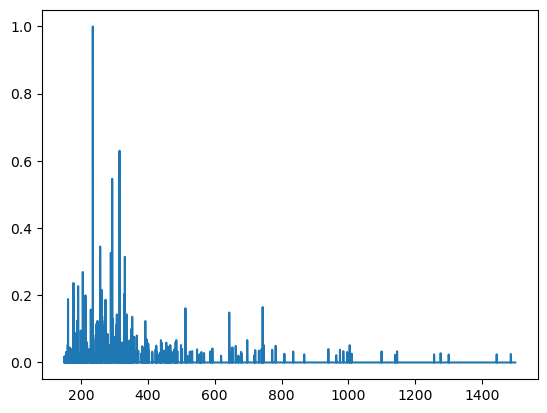

In [3]:
plt.plot(common_mzs[:len(common_mzs)-1],X[16])
plt.show()

In [4]:
print("NaN in training data:", np.isnan(X).any())
print("Input range:", np.min(X), "to", np.max(X))

NaN in training data: False
Input range: 0.0 to 0.9999899


In [5]:
name = f"../Data/LPS/sal_st.npy"

np.save(name, X)

In [6]:
name = f"../Data/LPS/sal_st_coords.npy"
np.save(name,coords)
name = f"../Data/LPS/sal_st_mzs.npy"
np.save(name,common_mzs)
